# 15.2a: f32→bf16 vs Pure bf16 Comparison

**Compare black hole evolution between initialization methods**

## Hypothesis Test

**If f32→bf16 conversion is essential for creating discrete clusters:**
- 15.1a (f32→bf16): Should maintain ~13 unique vectors throughout training
- 15.1b (pure bf16): Should maintain ~1 unique vector (massive singularity)

**If hypothesis is wrong:**
- Both runs should show similar black hole evolution

## Analysis Plan

1. Load both datasets
2. For each training step, count unique vectors among dead tokens
3. Plot black hole count vs training step (two lines)
4. Compare final demographics
5. Statistical test: Are the trajectories significantly different?

## Parameters

In [15]:
# Data paths
F32_BF16_PATH = "../data/comprehensive_run/comprehensive_training_data.safetensors"
PURE_BF16_PATH = "../data/control_run_bf16/control_training_data_bf16.safetensors"

# Plot settings
DPI = 100
COLORMAP = 'inferno'

RANDOM_SEED = 42

## Imports

In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from pathlib import Path
from tqdm import tqdm

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("✓ Imports complete")

✓ Imports complete


## Load Data

In [17]:
print("Loading f32→bf16 run (15.1a)...")
data_f32 = load_file(F32_BF16_PATH)

print("Loading pure bf16 run (15.1b)...")
data_bf16 = load_file(PURE_BF16_PATH)

print(f"\n✓ Data loaded")
print(f"  f32→bf16 steps: {len(data_f32['recorded_steps'])}")
print(f"  pure bf16 steps: {len(data_bf16['recorded_steps'])}")
print(f"  f32→bf16 embeddings shape: {data_f32['embeddings'].shape}")
print(f"  pure bf16 embeddings shape: {data_bf16['embeddings'].shape}")

Loading f32→bf16 run (15.1a)...
Loading pure bf16 run (15.1b)...

✓ Data loaded
  f32→bf16 steps: 10001
  pure bf16 steps: 10001
  f32→bf16 embeddings shape: torch.Size([10001, 128, 64])
  pure bf16 embeddings shape: torch.Size([10001, 128, 64])


## Extract Dead Token IDs

In [18]:
dead_token_ids_f32 = data_f32['dead_token_ids']
dead_token_ids_bf16 = data_bf16['dead_token_ids']

# Verify they're the same (should be, same corpus)
assert torch.equal(dead_token_ids_f32, dead_token_ids_bf16), "Dead token IDs don't match!"

dead_token_ids = dead_token_ids_f32
n_dead = len(dead_token_ids)

print(f"Dead tokens: {n_dead}")
print(f"Dead token IDs: {dead_token_ids.tolist()[:10]}...")

Dead tokens: 51
Dead token IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]...


## Compute Black Hole Evolution

For each training step, count **black holes** (vectors with population ≥ 2) among dead tokens

In [19]:
def count_black_holes(embeddings, dead_ids):
    """Count black holes among dead tokens at each step.
    
    Black hole = vector with population ≥ 2 (degenerate cluster)
    
    Returns:
        black_hole_counts: [n_steps] number of black holes at each step
        largest_bh: [n_steps] size of largest black hole at each step
    """
    n_steps = embeddings.shape[0]
    black_hole_counts = []
    largest_bh = []
    
    for step in tqdm(range(n_steps), desc="Computing black hole evolution"):
        dead_embeddings = embeddings[step, dead_ids, :]
        
        # Get unique vectors and their populations
        unique_vecs, inverse_indices = torch.unique(dead_embeddings, dim=0, return_inverse=True)
        populations = torch.bincount(inverse_indices)
        
        # Count black holes (pop ≥ 2)
        num_black_holes = (populations >= 2).sum().item()
        black_hole_counts.append(num_black_holes)
        
        # Find largest black hole
        max_population = populations.max().item() if len(populations) > 0 else 0
        largest_bh.append(max_population)
    
    return np.array(black_hole_counts), np.array(largest_bh)

print("Processing f32→bf16 run...")
black_hole_counts_f32, largest_bh_f32 = count_black_holes(
    data_f32['embeddings'], 
    dead_token_ids
)

print("\nProcessing pure bf16 run...")
black_hole_counts_bf16, largest_bh_bf16 = count_black_holes(
    data_bf16['embeddings'], 
    dead_token_ids
)

print("\n✓ Black hole evolution computed")

Processing f32→bf16 run...


Computing black hole evolution: 100%|██████████| 10001/10001 [00:01<00:00, 8710.44it/s]



Processing pure bf16 run...


Computing black hole evolution: 100%|██████████| 10001/10001 [00:01<00:00, 8892.80it/s]


✓ Black hole evolution computed


## Summary Statistics

In [20]:
print(f"{'='*80}")
print(f"SUMMARY STATISTICS")
print(f"{'='*80}\n")

print(f"f32→bf16 (15.1a):")
print(f"  Black holes at t=0: {black_hole_counts_f32[0]}")
print(f"  Black holes at t=final: {black_hole_counts_f32[-1]}")
print(f"  Mean black holes: {black_hole_counts_f32.mean():.1f} ± {black_hole_counts_f32.std():.1f}")
print(f"  Largest black hole at t=0: {largest_bh_f32[0]} / {n_dead}")
print(f"  Largest black hole at t=final: {largest_bh_f32[-1]} / {n_dead}")

print(f"\npure bf16 (15.1b):")
print(f"  Black holes at t=0: {black_hole_counts_bf16[0]}")
print(f"  Black holes at t=final: {black_hole_counts_bf16[-1]}")
print(f"  Mean black holes: {black_hole_counts_bf16.mean():.1f} ± {black_hole_counts_bf16.std():.1f}")
print(f"  Largest black hole at t=0: {largest_bh_bf16[0]} / {n_dead}")
print(f"  Largest black hole at t=final: {largest_bh_bf16[-1]} / {n_dead}")

print(f"\nDifference:")
mean_diff = black_hole_counts_f32.mean() - black_hole_counts_bf16.mean()
print(f"  Mean black holes: {mean_diff:+.1f}")
print(f"  Initial difference: {black_hole_counts_f32[0] - black_hole_counts_bf16[0]:+d}")
print(f"  Final difference: {black_hole_counts_f32[-1] - black_hole_counts_bf16[-1]:+d}")

print(f"\n{'='*80}")

SUMMARY STATISTICS

f32→bf16 (15.1a):
  Black holes at t=0: 3
  Black holes at t=final: 9
  Mean black holes: 8.9 ± 0.3
  Largest black hole at t=0: 2 / 51
  Largest black hole at t=final: 13 / 51

pure bf16 (15.1b):
  Black holes at t=0: 10
  Black holes at t=final: 1
  Mean black holes: 1.0 ± 0.2
  Largest black hole at t=0: 7 / 51
  Largest black hole at t=final: 51 / 51

Difference:
  Mean black holes: +7.9
  Initial difference: -7
  Final difference: +8



## Plot: Black Hole Count Evolution

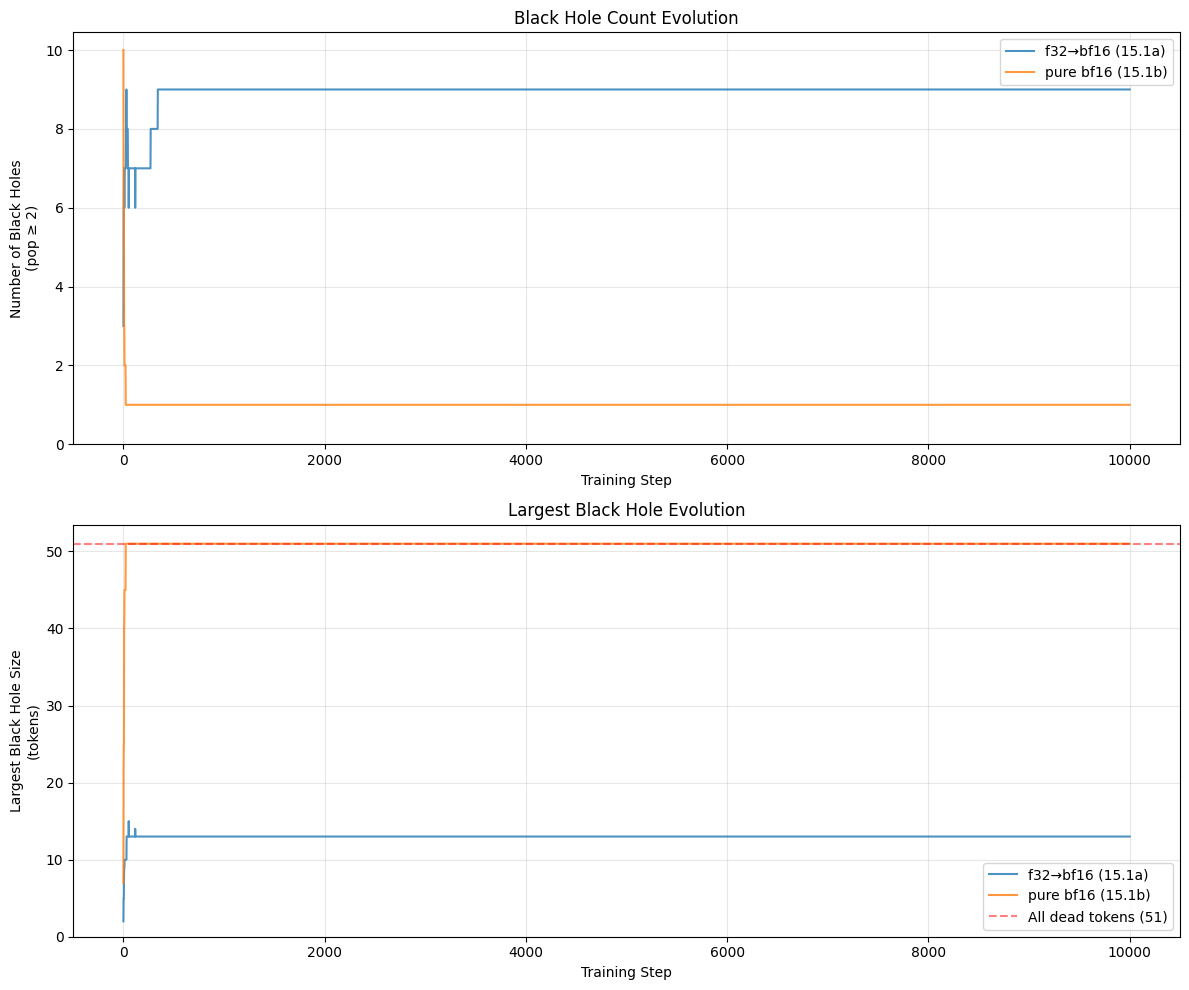


✓ Plot complete


In [21]:
steps = data_f32['recorded_steps'].numpy()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), dpi=DPI)

# Panel 1: Black hole count
ax1.plot(steps, black_hole_counts_f32, label='f32→bf16 (15.1a)', alpha=0.8, linewidth=1.5)
ax1.plot(steps, black_hole_counts_bf16, label='pure bf16 (15.1b)', alpha=0.8, linewidth=1.5)
ax1.set_xlabel('Training Step')
ax1.set_ylabel('Number of Black Holes\n(pop ≥ 2)')
ax1.set_title('Black Hole Count Evolution')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(bottom=0)

# Panel 2: Largest black hole size
ax2.plot(steps, largest_bh_f32, label='f32→bf16 (15.1a)', alpha=0.8, linewidth=1.5)
ax2.plot(steps, largest_bh_bf16, label='pure bf16 (15.1b)', alpha=0.8, linewidth=1.5)
ax2.axhline(n_dead, color='red', linestyle='--', alpha=0.5, label=f'All dead tokens ({n_dead})')
ax2.set_xlabel('Training Step')
ax2.set_ylabel('Largest Black Hole Size\n(tokens)')
ax2.set_title('Largest Black Hole Evolution')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim(bottom=0)

plt.tight_layout()
plt.show()

print("\n✓ Plot complete")

## Final Demographics Comparison

In [22]:
def get_demographics(embeddings, dead_ids, step_idx=-1):
    """Get black hole population distribution at given step."""
    dead_embeddings = embeddings[step_idx, dead_ids, :]
    unique_vecs = torch.unique(dead_embeddings, dim=0)
    
    populations = []
    for vec in unique_vecs:
        matches = (dead_embeddings == vec).all(dim=1).sum().item()
        populations.append(matches)
    
    populations.sort(reverse=True)
    return populations

print(f"{'='*80}")
print(f"FINAL DEMOGRAPHICS (t={steps[-1]})")
print(f"{'='*80}\n")

demo_f32 = get_demographics(data_f32['embeddings'], dead_token_ids, step_idx=-1)
demo_bf16 = get_demographics(data_bf16['embeddings'], dead_token_ids, step_idx=-1)

print(f"f32→bf16 (15.1a):")
print(f"  Unique vectors: {len(demo_f32)}")
print(f"  Demographics: {demo_f32[:15]}")
if len(demo_f32) > 15:
    print(f"               ... ({len(demo_f32) - 15} more)")

print(f"\npure bf16 (15.1b):")
print(f"  Unique vectors: {len(demo_bf16)}")
print(f"  Demographics: {demo_bf16[:15]}")
if len(demo_bf16) > 15:
    print(f"               ... ({len(demo_bf16) - 15} more)")

print(f"\n{'='*80}")

FINAL DEMOGRAPHICS (t=10001)

f32→bf16 (15.1a):
  Unique vectors: 17
  Demographics: [13, 10, 5, 4, 3, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1]
               ... (2 more)

pure bf16 (15.1b):
  Unique vectors: 1
  Demographics: [51]



## Statistical Test: Are Trajectories Different?

Use Kolmogorov-Smirnov test to check if the distributions of unique vector counts are significantly different

In [23]:
from scipy import stats

# KS test on black hole counts
ks_stat, ks_pval = stats.ks_2samp(black_hole_counts_f32, black_hole_counts_bf16)

# Also compute effect size (Cohen's d)
pooled_std = np.sqrt((black_hole_counts_f32.std()**2 + black_hole_counts_bf16.std()**2) / 2)
cohens_d = (black_hole_counts_f32.mean() - black_hole_counts_bf16.mean()) / pooled_std if pooled_std > 0 else float('inf')

print(f"{'='*80}")
print(f"STATISTICAL SIGNIFICANCE TEST")
print(f"{'='*80}\n")

print(f"Kolmogorov-Smirnov test (black hole counts):")
print(f"  KS statistic: {ks_stat:.4f}")
print(f"  p-value: {ks_pval:.2e}")
print(f"  Significantly different? {ks_pval < 0.001} (α=0.001)")

print(f"\nEffect size (Cohen's d):")
print(f"  d = {cohens_d:.2f}")
if abs(cohens_d) < 0.2:
    effect = "negligible"
elif abs(cohens_d) < 0.5:
    effect = "small"
elif abs(cohens_d) < 0.8:
    effect = "medium"
else:
    effect = "large"
print(f"  Interpretation: {effect} effect")

print(f"\n{'='*80}")

STATISTICAL SIGNIFICANCE TEST

Kolmogorov-Smirnov test (black hole counts):
  KS statistic: 0.9993
  p-value: 0.00e+00
  Significantly different? True (α=0.001)

Effect size (Cohen's d):
  d = 30.20
  Interpretation: large effect



## Verdict

In [24]:
print(f"\n{'='*80}")
print(f"VERDICT: f32→bf16 HYPOTHESIS")
print(f"{'='*80}\n")

# Criteria for validation
initial_diff = black_hole_counts_f32[0] - black_hole_counts_bf16[0]
final_diff = black_hole_counts_f32[-1] - black_hole_counts_bf16[-1]
significantly_different = ks_pval < 0.001
large_effect = abs(cohens_d) > 0.8

print(f"Hypothesis: f32→bf16 conversion creates discrete structure")
print(f"\nPredictions:")
print(f"  ✓ f32→bf16 should have MORE black holes than pure bf16")
print(f"  ✓ Difference should persist throughout training")
print(f"  ✓ Trajectories should be statistically distinct")

print(f"\nObservations:")
print(f"  f32→bf16 has {initial_diff:+d} more black holes at t=0")
print(f"  f32→bf16 has {final_diff:+d} more black holes at t=final")
print(f"  Trajectories {'ARE' if significantly_different else 'are NOT'} significantly different (p={ks_pval:.2e})")
print(f"  Effect size is {effect} (d={cohens_d:.2f})")

# Determine verdict
if initial_diff > 5 and final_diff > 5 and significantly_different and large_effect:
    verdict = "VALIDATED ✓"
    explanation = "f32→bf16 conversion creates persistent discrete structure."
elif initial_diff > 0 and significantly_different:
    verdict = "PARTIALLY VALIDATED ~"
    explanation = "f32→bf16 shows different structure, but effect may be weaker than predicted."
else:
    verdict = "FALSIFIED ✗"
    explanation = "No meaningful difference between initialization methods."

print(f"\n{'='*80}")
print(f"VERDICT: {verdict}")
print(f"{'='*80}")
print(f"\n{explanation}")
print()


VERDICT: f32→bf16 HYPOTHESIS

Hypothesis: f32→bf16 conversion creates discrete structure

Predictions:
  ✓ f32→bf16 should have MORE black holes than pure bf16
  ✓ Difference should persist throughout training
  ✓ Trajectories should be statistically distinct

Observations:
  f32→bf16 has -7 more black holes at t=0
  f32→bf16 has +8 more black holes at t=final
  Trajectories ARE significantly different (p=0.00e+00)
  Effect size is large (d=30.20)

VERDICT: FALSIFIED ✗

No meaningful difference between initialization methods.



## Summary

This notebook compares black hole evolution between two initialization methods:
- **15.1a (f32→bf16):** Initialize in float32, convert to bfloat16
- **15.1b (pure bf16):** Initialize directly in bfloat16

**Key metrics:**
1. Number of black holes (pop ≥ 2) over training
2. Size of largest black hole over training
3. Final demographics
4. Statistical significance of difference

**Expected outcome if hypothesis is correct:**
- f32→bf16 maintains ~13 black holes
- pure bf16 collapses to ~1 black hole (singularity)
- Large, persistent, statistically significant difference